In [3]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

N = scipy.stats.norm.cdf
n = scipy.stats.norm.pdf

sns.set_style("whitegrid")

In [8]:
class GBM():
    
    def __init__(self, sigma, mu, S0, T=2, dt=0.01):
        
        self.sigma = sigma
        self.mu = mu
        self.S0 = S0
        self.T = T
        self.dt = dt 
        
        norm = scipy.stats.norm.rvs(0, np.sqrt(dt), size = int(round(T/dt))) 
        
        Wt = np.cumsum(norm) #brownian motion
        Wt_anthitetic = np.cumsum(-norm)
        
        self.trajectory = np.concatenate([np.array([self.S0]), self.S0*np.exp((mu-(self.sigma**2)/2)*np.arange(dt, T, step=dt) + self.sigma*Wt[:-1])])
        self.antithetic_trajectory = np.concatenate([np.array([self.S0]), self.S0*np.exp((mu-(self.sigma**2)/2)*np.arange(dt, T, step=dt) + self.sigma*Wt_anthitetic[:-1])])
                
    def plot(self):
        
        plt.plot(np.arange(self.T, step = self.dt), self.trajectory)
        plt.xlabel("t")
        plt.ylabel("S(t)")
        plt.show()
        
                      
class Option():
    
    def __init__(self, K, brownian_motion, option_type):
        
        self.K = K
        self.brownian_motion = brownian_motion  
        self.r = self.brownian_motion.mu 
        self.option_type = option_type
        
    def d1(self, t):
        return (np.log(self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))]/self.K) + (self.r + (self.brownian_motion.sigma)**2/2)*(self.brownian_motion.T - t)) / (self.brownian_motion.sigma*np.sqrt(self.brownian_motion.T - t))
     
    def d2(self, t):
        return self.d1(t) - self.brownian_motion.sigma * np.sqrt(self.brownian_motion.T - t)       
        
    def price_option(self, t=0):
        
        if self.option_type == "call":
            return self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))] * N(self.d1(t)) - self.K * np.exp(-self.r*(self.brownian_motion.T-t))* N(self.d2(t))
        elif self.option_type == "put":
            return self.K*np.exp(-self.r*(self.brownian_motion.T-t))*N(-self.d2(t)) - self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))]*N(-self.d1(t))

    def delta(self, t=0):
        
        if self.option_type == "call":
            return N(self.d1(t))
        
        elif self.option_type == "put":
            return N(self.d1(t)) - 1
        
    def gamma(self, t=0):
        
        return n(self.d1(t))/(self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))]*self.brownian_motion.sigma*np.sqrt(self.brownian_motion.T - t))
    
    def payoff(self):
        
        if self.option_type == "call":
            return np.max([self.brownian_motion.trajectory[-1] - self.K, 0])
        
        elif self.option_type == "put":
            return np.max([self.K - self.brownian_motion.trajectory[-1], 0])
    
    def lookback_payoff(self):
        if self.option_type == "call":
            return np.max([self.brownian_motion.trajectory[-1] - np.min(self.brownian_motion.trajectory), 0])
        elif self.option_type == "put":
            return np.max([np.min(self.brownian_motion.trajectory) - self.brownian_motion.trajectory[-1], 0])
       

In [5]:
#basic simulation

sigma = 0.05
mu = 0.1
r = mu
S0 = 100
sim_num = 1000000
T = 2
dt=0.001

pay_off_list = np.zeros(sim_num) #list of payoffs
X_list = np.zeros(sim_num)

for sim in np.arange(sim_num): #10^6 simulations
    option = Option(S0, GBM(sigma, mu, S0, T=T, dt=dt), "call") #call option, K=S0
    pay_off_list[sim] = option.payoff()
    X_list[sim] = option.brownian_motion.trajectory[-1]
    
pay_off_list = np.exp(-r*T)*pay_off_list
    

In [6]:
option_price = option.price_option()

In [15]:
#accuracy 

alpha=0.05
N_list = (10, 100, 1000, 10000, 100000, 1000000)
z = scipy.stats.norm.ppf(1 - alpha/2)

lower_boundry = np.zeros(len(N_list))
value = np.zeros(len(N_list))
upper_boundry = np.zeros(len(N_list))

for i, N in enumerate(N_list):
    std = np.std(pay_off_list[:N])
    lower_boundry[i] = option_price - z*std/np.sqrt(N)
    upper_boundry[i] = option_price + z*std/np.sqrt(N)
    value[i] = np.mean(pay_off_list[:N])

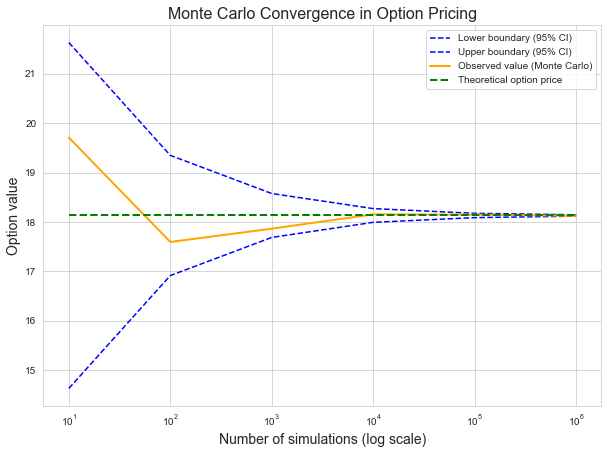

In [57]:
#outcome

plt.figure(figsize=(10,7))

plt.plot(N_list, lower_boundry, label="Lower boundary (95% CI)", color="blue", linestyle="--", linewidth=1.5)
plt.plot(N_list, upper_boundry, label="Upper boundary (95% CI)", color="blue", linestyle="--", linewidth=1.5)
plt.plot(N_list, value, label="Observed value (Monte Carlo)", color="orange", linewidth=2)
plt.plot(N_list, [option_price for _ in np.arange(len(N_list))], 
         color="green", linestyle="--", linewidth=2, label="Theoretical option price")


plt.xlabel("Number of simulations (log scale)", fontsize=14)
plt.ylabel("Option value", fontsize=14)


plt.title("Monte Carlo Convergence in Option Pricing", fontsize=16)

plt.legend()
plt.xscale("log")

In [64]:
#control variates - let it be asset value at T

expected_cv_val = np.exp(r*T)*S0

#accuracy 

N_list = (10, 100, 1000, 10000, 100000, 1000000)

value = np.zeros(len(N_list))

for i, N in enumerate(N_list):
    
    value[i] = np.mean(pay_off_list[:N]) + (expected_cv_val - np.mean(X_list[:N]))

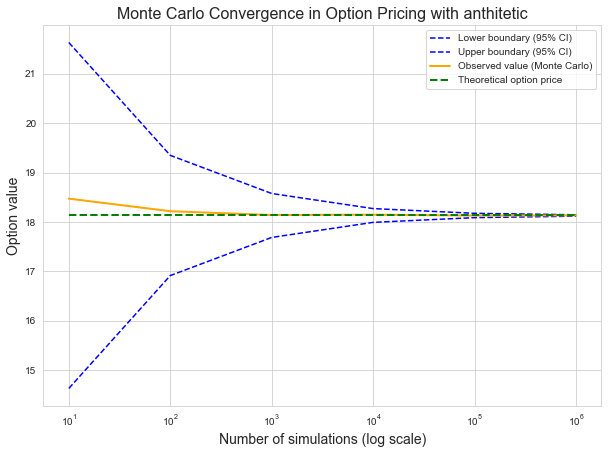

In [65]:
#outcome
plt.figure(figsize=(10,7))

plt.plot(N_list, lower_boundry, label="Lower boundary (95% CI)", color="blue", linestyle="--", linewidth=1.5)
plt.plot(N_list, upper_boundry, label="Upper boundary (95% CI)", color="blue", linestyle="--", linewidth=1.5)
plt.plot(N_list, value, label="Observed value (Monte Carlo)", color="orange", linewidth=2)
plt.plot(N_list, [option_price for _ in np.arange(len(N_list))], 
         color="green", linestyle="--", linewidth=2, label="Theoretical option price")


plt.xlabel("Number of simulations (log scale)", fontsize=14)
plt.ylabel("Option value", fontsize=14)


plt.title("Monte Carlo Convergence in Option Pricing with anthitetic", fontsize=16)

plt.legend()
plt.xscale("log")

In [59]:
#anthitetic

pay_off_list = np.zeros(sim_num) #list of payoffs

for sim in np.arange(sim_num): #10^6 simulations
    gbm = GBM(sigma, mu, S0, T=T, dt=dt) #call option, K=S0
    
    pay_off = np.max([gbm.trajectory[-1] - S0, 0])
    pay_off_anthitetic = np.max([gbm.antithetic_trajectory[-1] - S0, 0])
    pay_off_list[sim] = np.mean([pay_off, pay_off_anthitetic])
    
pay_off_list = np.exp(-r*T)*pay_off_list

In [60]:
#accuracy 

N_list = (10, 100, 1000, 10000, 100000, 1000000)

value = np.zeros(len(N_list))

for i, N in enumerate(N_list):
    value[i] = np.mean(pay_off_list[:N])

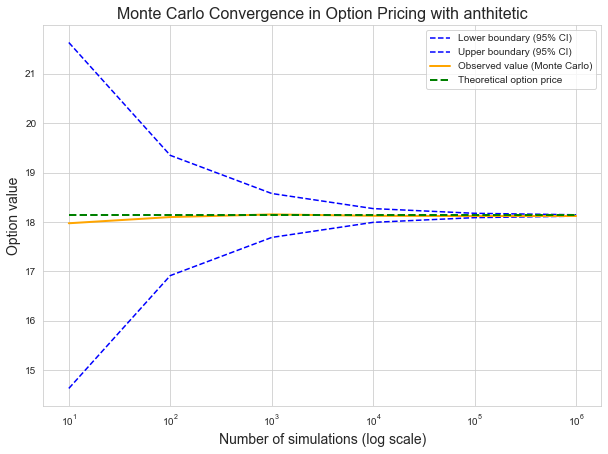

In [61]:
#outcome

plt.figure(figsize=(10,7))

plt.plot(N_list, lower_boundry, label="Lower boundary (95% CI)", color="blue", linestyle="--", linewidth=1.5)
plt.plot(N_list, upper_boundry, label="Upper boundary (95% CI)", color="blue", linestyle="--", linewidth=1.5)
plt.plot(N_list, value, label="Observed value (Monte Carlo)", color="orange", linewidth=2)
plt.plot(N_list, [option_price for _ in np.arange(len(N_list))], 
         color="green", linestyle="--", linewidth=2, label="Theoretical option price")


plt.xlabel("Number of simulations (log scale)", fontsize=14)
plt.ylabel("Option value", fontsize=14)


plt.title("Monte Carlo Convergence in Option Pricing with anthitetic", fontsize=16)

plt.legend()
plt.xscale("log")

### Results for enhanced Lookback option

In [9]:
#anthitetic

pay_off_list_L = np.zeros(sim_num) #list of payoffs

for sim in np.arange(sim_num): #10^6 simulations
    gbm = GBM(sigma, mu, S0, T=T, dt=dt) #call option, K=S0
    
    pay_off_L = np.max([gbm.trajectory[-1] - S0, 0])
    pay_off_anthitetic_L = np.max([gbm.antithetic_trajectory[-1] - S0, 0])
    pay_off_list_L[sim] = np.mean([pay_off_L, pay_off_anthitetic_L])
    
pay_off_list_L = np.exp(-r*T)*pay_off_list_L

In [10]:
N_list = (10, 100, 1000, 10000, 100000, 1000000)

valueL = np.zeros(len(N_list))

for i, N in enumerate(N_list):
    valueL[i] = np.mean(pay_off_list_L[:N])

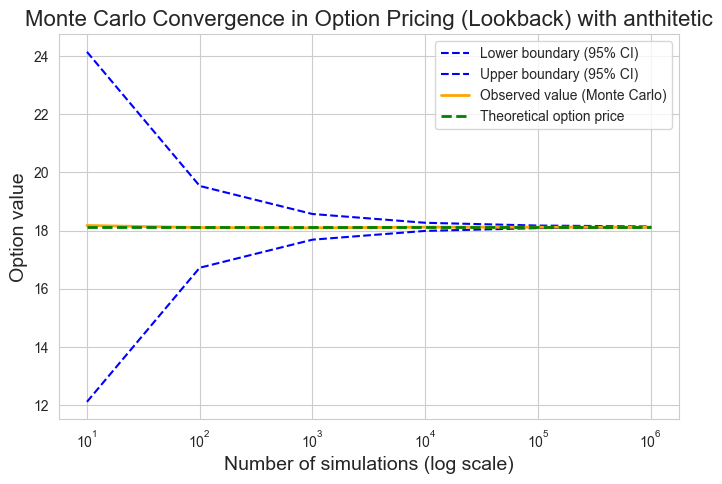

In [16]:
plt.figure(figsize=(8,5))

plt.plot(N_list, lower_boundry, label="Lower boundary (95% CI)", color="blue", linestyle="--", linewidth=1.5)
plt.plot(N_list, upper_boundry, label="Upper boundary (95% CI)", color="blue", linestyle="--", linewidth=1.5)
plt.plot(N_list, valueL, label="Observed value (Monte Carlo)", color="orange", linewidth=2)
plt.plot(N_list, [option_price for _ in np.arange(len(N_list))], 
         color="green", linestyle="--", linewidth=2, label="Theoretical option price")


plt.xlabel("Number of simulations (log scale)", fontsize=14)
plt.ylabel("Option value", fontsize=14)


plt.title("Monte Carlo Convergence in Option Pricing (Lookback) with anthitetic", fontsize=16)

plt.legend()
plt.xscale("log")